# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
import sys
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    find_id,
    get_ABS_meta_and_data,
    get_fs_constants,
    get_meta_constants,
)
from plotting import clear_chart_dir, line_plot, set_chart_dir

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = True

## Get data from ABS

In [2]:
# ABS data extraction settings
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

In [3]:
abs_data = {}


def get_abs(catalogue_id: str) -> dict:
    if catalogue_id not in abs_data:
        abs_dict = get_ABS_meta_and_data(catalogue_id)
        if abs_dict is None:
            sys.exit(-1)
        abs_data[catalogue_id] = abs_dict
        return abs_dict

    return abs_data[catalogue_id]

In [4]:
sources = set()


def get_series(
    catalogue_id: str, table: str, series_type: str, did_type: str, series_name: str
) -> pd.Series:
    # get the ABS data
    data_dict = get_abs(catalogue_id)
    sources.add(catalogue_id)
    _, _, META_DATA = get_fs_constants(catalogue_id)
    meta = data_dict[META_DATA]
    data = data_dict[table]

    # get the identified series
    search_terms = {
        table: table_col,
        "Seasonally Adjusted" if series_type == "SA" else "Original": type_col,
        did_type: did_col,
        series_name: did_col,
    }
    series_id, _ = find_id(meta, search_terms, verbose=True)
    series = data[series_id]

    return series

In [5]:
def calculate_growth(series, name, did_type):
    """Work out if we need to calculate annual growth,
       and if we do, then calculate growth. 
       Return a series of percentage growth."""

    # preliminary
    period = series.index.freqstr[0]
    shift = 4 if period == "Q" else 12 if period == "M" else 0
    if not shift:
        print(f"--- Something odd---: {name} {series.index.freqstr}")

    # treat series appropriately 
    # -- already annual growth, so no treatment needed
    dt_lower = did_type.lower()
    if "percent" in dt_lower and "previous year" in dt_lower:
        growth = series
        
    # -- calculate annual growth from raw series
    else:
        growth = series.pct_change(periods=shift) * 100

    # upsample quarterly data to monthly before returning it
    if period == 'Q':
        growth = growth.resample("M", convention="end").mean()

    return growth

In [6]:
capture = {
    # specify the data items we wish to capture ...
    # raw data - we will calculate growth from index numbers/etc.
    # description: [catalogue_id, table, series_type, did_type, series_name, summary]
    "All Groups CPI": [
        "6401",
        "2",
        "Orig",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "All groups CPI ;  Australia ;",
        "CPI",
    ],
    "CPI Trimmed Mean": [
        "6401",
        "8",
        "SA",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "Trimmed Mean ;  Australia ;",
        "CPI-TM",
    ],
    "Monthly CPI Indicator": [
        "6484",
        "1",
        "SA",
        "Percentage Change from Corresponding Month of Previous Year",
        "All groups CPI, seasonally adjusted ;  Australia",
        "M-CPI",
    ],
    "Producer Price Index": [
        "6427",
        "1",
        "Orig",
        "Percentage change from corresponding quarter of previous year",
        "Final ;  Total ",
        "PPI",
    ],
    "Wage Price Index": [
        "6345",
        "1",
        "SA",
        "Percentage Change From Corresponding Quarter of Previous Year",
        "Australia ;  Total hourly rates of pay excluding bonuses ;  Private and Public ;  All industries ;",
        "WPI",
    ],
    "GDP Price Deflator": ["5206", "5", "SA", " ", "GROSS DOMESTIC PRODUCT ;", "GDP"],
    "Households final consumption Price Deflator": [
        "5206",
        "5",
        "SA",
        " ",
        "Households ;  Final consumption expenditure ;",
        "HFCE",
    ],
    "Non-farm hourly employee compensation": [
        "5206",
        "24",
        "SA",
        "Current prices ;",
        "Non-farm compensation of employees per hour:",
        "NFHEC",
    ],
}

# let's download the ABS data
combined = {}
latest = []
for name, (
    catalogue_id,
    table,
    series_type,
    did_type,
    series_name,
    summary,
) in capture.items():
    series = get_series(catalogue_id, table, series_type, did_type, series_name)
    growth = calculate_growth(series, name, did_type)
    full_name = f"{name} ({series_type})"
    growth.name = full_name
    combined[full_name] = growth
    latest.append(f"{summary}={round(growth.dropna().iloc[-1], 1)}")

frame = pd.DataFrame(combined)
source = f"ABS {', '.join(sorted(sources))}"
latest = f"Latest reported: {', '.join(latest)}."
print("\n", latest)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...

 Latest reported: CPI=5.4, CPI-TM=5.2, M-CPI=4.8, PPI=3.8, WPI=4.0, GDP=2.4, HFCE=5.6, NFHEC=4.1.


## Plot the data

In [7]:
# plot settings
CHART_DIR = "./CHARTS/Inflation"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")

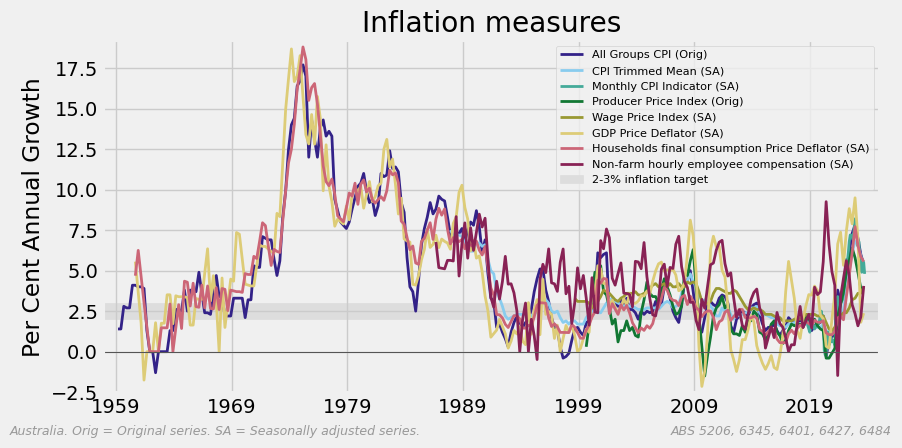

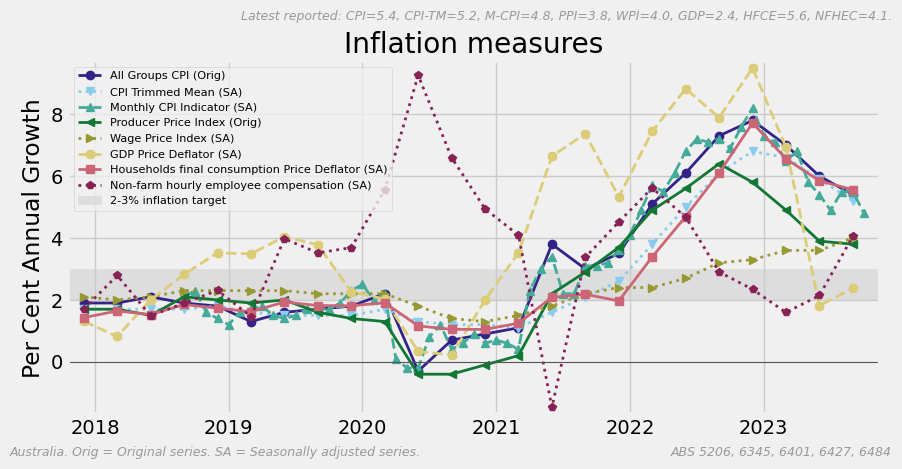

In [8]:
target = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}
starts = ("1959-01-01", "2017-11-01")
styles = (None, ["solid", "dotted", "dashed"] * 3)
markers = (
    None,
    ["o", "v", "^", "<", ">", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"],
)

for start, style, marker in zip(starts, styles, markers):
    line_plot(
        frame,
        starts=start,
        style=style,
        marker=marker,
        markersize=6,
        dropna=True,
        title="Inflation measures",
        ylabel="Per Cent Annual Growth",
        legend={"fontsize": "xx-small"},
        axhspan=target,
        y0=True,
        rfooter=source,
        lfooter="Australia. Orig = Original series. "
                "SA = Seasonally adjusted series. ",
        rheader=latest if start != starts[0] else None,
        tags=start if start is not None else "",
        show=SHOW,
    )

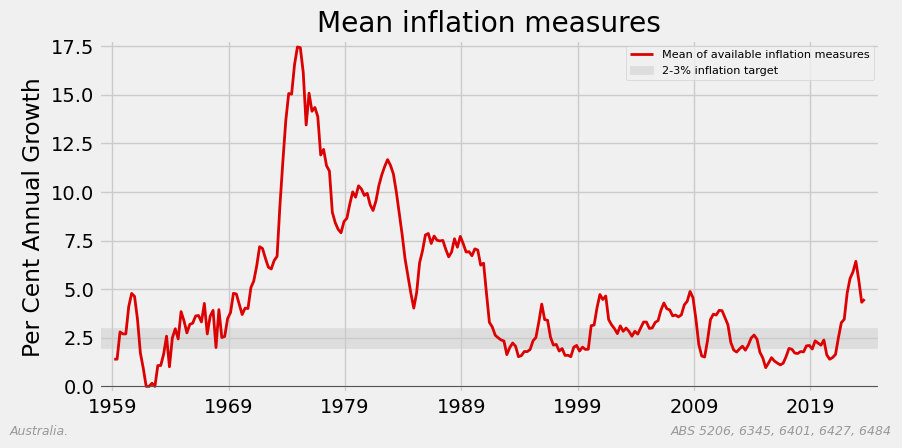

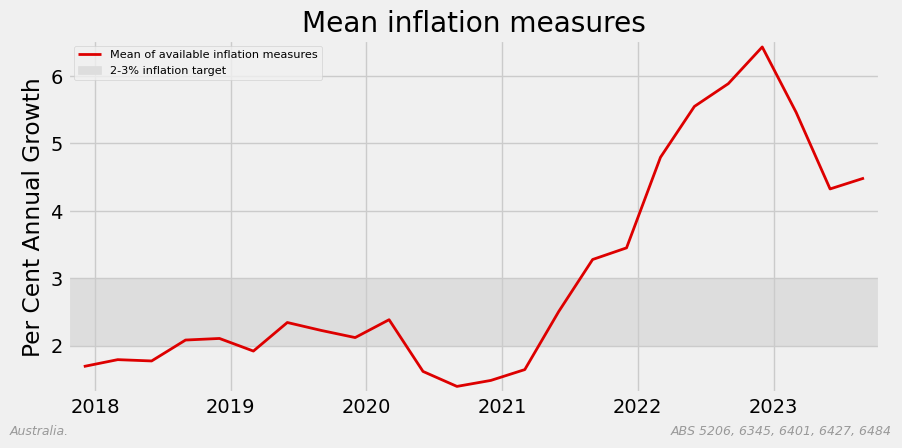

In [9]:
# Not sure this averaging is really meaningful, or comparable over time.
# but it simplifies the story somewhat

# Calculate mean for quarterly data only
mean_inflation = frame.loc[frame.index.month.isin((3, 6, 9, 12))].mean(axis=1)
mean_inflation.name = "Mean of available inflation measures"

# plot
for start in starts:
    line_plot(
        mean_inflation,
        starts=start,
        title="Mean inflation measures",
        ylabel="Per Cent Annual Growth",
        legend={"fontsize": "xx-small"},
        axhspan=target,
        y0=True,
        rfooter=source,
        lfooter="Australia. ",
        tags=start if start is not None else "",
        show=SHOW,
    )

## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Dec 07 2023 11:36:59

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.1

matplotlib: 3.8.2
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
pandas    : 2.1.3

Watermark: 2.4.3



In [11]:
print("Finished")

Finished
